In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision, Time Series, and Survival Analysis (Lectures 19 to 20) 

**Due date: see the [Apr 07, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

Depending on type and regions of Avocado grew from, we get different prices. We can see that for the same date, different combinations of region and type of avocadoes have different average price. Additionally, with 54 unique regions, and two unique types, we can have at most 108 different measurements for each combination of regions and type.

In [9]:
# Check the unique regions and types
print("Unique regions:", df['region'].nunique())
print("Unique types:", df['type'].unique())

Unique regions: 54
Unique types: ['conventional' 'organic']


In [10]:
sample_date = df['Date'].iloc[0]
print(sample_date)

2015-12-27 00:00:00


In [11]:
sample = df[df['Date'] == sample_date][['Date', 'region', 'type', 'AveragePrice']]
sample.sort_values(['region', 'type'])

,Date,region,type,AveragePrice
0,2015-12-27,Albany,conventional,1.33
0,2015-12-27,Albany,organic,1.83
0,2015-12-27,Atlanta,conventional,0.99
0,2015-12-27,Atlanta,organic,1.84
0,2015-12-27,BaltimoreWashington,conventional,1.17
...,...,...,...,...
0,2015-12-27,TotalUS,organic,1.52
0,2015-12-27,West,conventional,0.83
0,2015-12-27,West,organic,1.46
0,2015-12-27,WestTexNewMexico,conventional,0.71


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

For the time space distribution, we cannot whether the data has equal measurements based on one categorical data alone, we as we can see that both type and region repeat multiple time within the same day, so we have to consider both the categorical variables when considering if the data has equally spaced measurements. From what we can see that in combination of type variables and region variable, the measurement for each combination is spaced out every 7 days, as seen in the measurements for Albany with both type of avocadoes

Reference: Most of the codes and functions were adapted from Lecture 20 Notes of Professor Lecuyer

In [12]:
def plot_time_spacing_distribution_region(df, region="Adelaide"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[(df['region'] == region)].sort_values('Date')
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region} :\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.days.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [13]:
def plot_time_spacing_distribution_type(df, avocado_type = "conventional"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    type_data = df[(df['type'] == avocado_type)].sort_values('Date')
    
    if type_data.empty:
        print(f"No data available for type: {avocado_type}")
        return
    
    # Calculate time differences
    time_diffs = type_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {avocado_type}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.days.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {avocado_type}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_time_spacing_distribution(df, region="Adelaide", avocado_type="conventional"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_type_data = df[(df['region'] == region) & (df['type'] == avocado_type)].sort_values('Date')
    
    if region_type_data.empty:
        print(f"No data available for region: {region}, type: {avocado_type}")
        return
    
    # Calculate time differences
    time_diffs = region_type_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region} ({avocado_type}):\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.days.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region} ({avocado_type})")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Time spacing counts for Albany :
Date
0 days    169
7 days    168
Name: count, dtype: int64



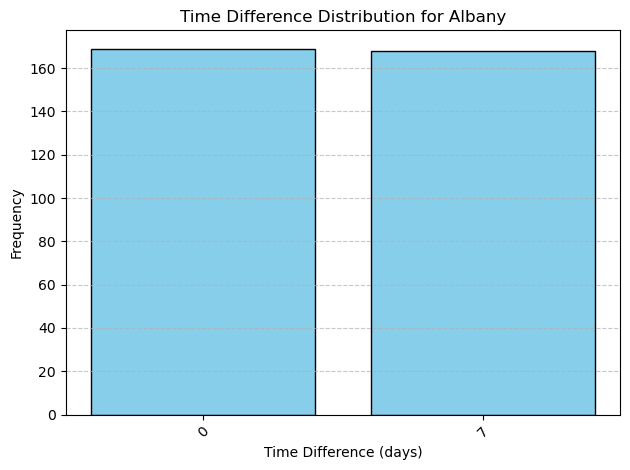

In [15]:
plot_time_spacing_distribution_region(df, "Albany")

Time spacing counts for organic:
Date
0 days    8954
7 days     168
Name: count, dtype: int64



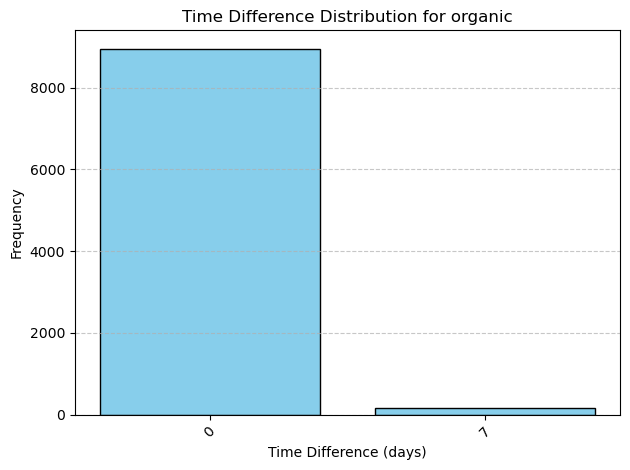

In [16]:
plot_time_spacing_distribution_type(df, "organic")

Time spacing counts for Albany (organic):
Date
7 days    168
Name: count, dtype: int64



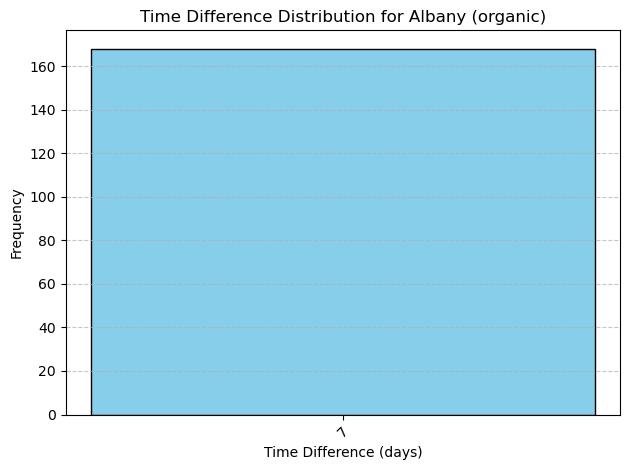

In [17]:
plot_time_spacing_distribution(df,"Albany","organic")

Time spacing counts for Albany (conventional):
Date
7 days    168
Name: count, dtype: int64



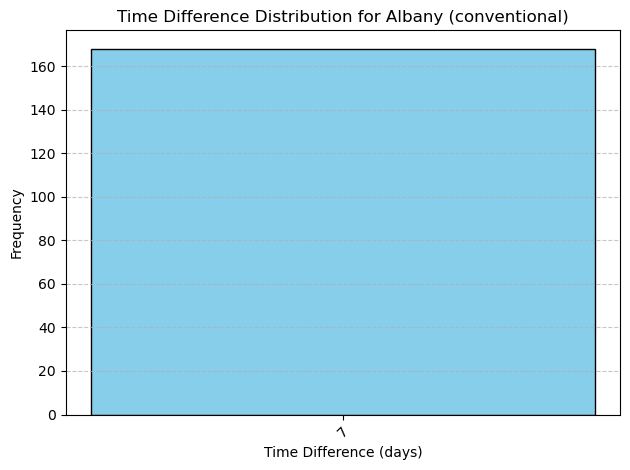

In [18]:
plot_time_spacing_distribution(df,"Albany","conventional")

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

By looking at the list of the regions name in the dataset, we can see that some regions overlapping each other. For example, we have TotalUS region, which refer to the average avocado price all over US, and yet we also have avocadoes prices from each states, and cities

In [19]:
# Get unique region names
regions = sorted(df['region'].unique())

# Display the list
print(pd.DataFrame(regions))

                      0
0                Albany
1               Atlanta
2   BaltimoreWashington
3                 Boise
4                Boston
5      BuffaloRochester
6            California
7             Charlotte
8               Chicago
9      CincinnatiDayton
10             Columbus
11        DallasFtWorth
12               Denver
13              Detroit
14          GrandRapids
15           GreatLakes
16   HarrisburgScranton
17  HartfordSpringfield
18              Houston
19         Indianapolis
20         Jacksonville
21             LasVegas
22           LosAngeles
23           Louisville
24    MiamiFtLauderdale
25             Midsouth
26            Nashville
27     NewOrleansMobile
28              NewYork
29            Northeast
30   NorthernNewEngland
31              Orlando
32         Philadelphia
33        PhoenixTucson
34           Pittsburgh
35               Plains
36             Portland
37    RaleighGreensboro
38      RichmondNorfolk
39              Roanoke
40           Sac

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures), with some improvements.

In [20]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [21]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [22]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [23]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

The $R^2$ score on the train data is 0.83, and the $R^2$ on the test score is 0.76. While the approach is simple, the dummy model obviously does not do well on the test set

In [24]:
df_train_predictions = df_train["AveragePrice"]
df_train_predictions

0        1.22
1        1.24
2        1.17
3        1.06
4        0.99
         ... 
18218    2.50
18219    2.39
18220    2.38
18221    2.36
18222    2.26
Name: AveragePrice, Length: 15441, dtype: float64

In [25]:
df_test_predictions = df_test["AveragePrice"]
df_test_predictions

143      1.69
144      1.78
145      1.65
146      1.56
147      1.67
         ... 
18243    1.56
18244    1.57
18245    1.54
18246    1.56
18247    1.56
Name: AveragePrice, Length: 2700, dtype: float64

In [26]:
train_r2 = r2_score(df_train['AveragePriceNextWeek'], df_train_predictions)
test_r2 = r2_score(df_test['AveragePriceNextWeek'], df_test_predictions)

In [27]:
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train R^2: 0.8285800937261841
Test R^2: 0.7631780188583048


In [28]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

First we built a model to predict the average avocado price next week without any feature engineering for the dates. From our observations, it seems that this model itself perform pretty well since the model doesn't seem to be overfitting on the test set, and the $R^2$ score of both training and test set are still pretty high around 0.80 to 0.85. Meanwhile looking at the cross-validation score, is not too high but not too low either at 0.80. In fact, all the other approaches for encoding the date gave us similar cross-validation score. Hence that metric is not quite useful in telling us which model is performing better than the other. So we will stick with $R^2$ of the test set to evaluate the model performance. 
    
Next, we look at the model performance when the date is encoded as the day since the data was first recorded. From our observation, we can see that the further away you are from the minimum recorded date in the dataset, the higher avocado average price are. However the $R^2$ score of this model is lower than the model without date encoding, and the added variables only increase the price at about 0.03, so this variable doesn't change the model result alot. This tell us that this method of encoding might not be helpful for our model.
    
The third method of encoding that we did was creating another variable classifying the date into its month. The $R^2$ test score of this model is not higher than the first model. Howver, it gave us variables that explains the fluctuation in avocado prices. Interestingly, between the month of May to October, the average avocado prices are generally higher than other months given that other variables in the model stay constants. This can be explain that people usually eat avocadoes during the summer, and maybe early fall, so that might increase the price of the product.
    
The fourth method of date encoding that we did was adding another variable classifying the data into its appropriate season. This model did slightly poorer than the third method with $R^2$ of test score at 0.79. Additionally, the variables coefficients are pretty similar to the month addition to the variable, where the season of summer and fall the average avocadoes price will increase in comparison to winter and spring, given that other variables stays constants. Since the additional variable gave us similar insight to the third model, while the test score also did worse.
    
Overall, it seems that the highest $R^2$ test score that we can get for our model is 0.80, and the models that performed best were the model without any Date feature encoding, and the model with the additional Feature of Month. Depending on how users would want to use this model for. If the users just want a simple model that perform well, the model without date feature engineering might be good to use. However, if the user want to use model that perform just as well, and give more explanation, the model with Month feature encoding is quite helpful

Reference: Most of the codes and functions were adapted from Lecture 20 Notes of Professor Lecuyer

### Model without `Date` Feature Engineering

In [29]:
avo_dates = df_train["Date"]
avo_dates.min()

Timestamp('2015-01-04 00:00:00')

In [30]:
avo_dates.max()

Timestamp('2017-09-24 00:00:00')

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15441 entries, 0 to 18222
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNextWeek 

In [32]:
numeric_features = [
    "AveragePrice",
    "Total Volume",
    "4046",
    "4225",
    "4770",
    "Total Bags",
    "Small Bags",
    "Large Bags",
    "XLarge Bags"
]
categorical_features = [
    "type",
    "region",
    "year"
]
drop_features = ["Date"]
target = ["AveragePriceNextWeek"]

In [33]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [34]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features,
    drop_features, target
)

In [35]:
X_train_enc.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type_conventional,...,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,year_2015,year_2016,year_2017
0,-0.432512,-0.234535,-0.229503,-0.222203,-0.214954,-0.232206,-0.229907,-0.223154,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.383676,-0.234440,-0.230948,-0.219448,-0.214272,-0.233587,-0.231513,-0.223789,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.554604,-0.233469,-0.231018,-0.219530,-0.214196,-0.229850,-0.226469,-0.224325,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.823205,-0.233283,-0.230996,-0.218170,-0.213945,-0.230999,-0.228629,-0.222193,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.994133,-0.225747,-0.230668,-0.196131,-0.213811,-0.232627,-0.229930,-0.224856,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [36]:
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=100))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["ridge"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [37]:
score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.325180
region_SanFrancisco,0.091341
region_HartfordSpringfield,0.088819
region_NewYork,0.070054
type_organic,0.051681
...,...
region_Denver,-0.047878
type_conventional,-0.051681
region_SouthCentral,-0.067115
region_DallasFtWorth,-0.068354


In [38]:
train_df_ordered = df_train.sort_values(by=["Date"])
y_train_ordered = train_df_ordered["AveragePriceNextWeek"]

In [39]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
cross_val_score(lr_pipe, train_df_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

0.8034591020878092

Without feature engineering the test score is still pretty high with 0.80, and so is the training corss vailidation score

### Encoding `Date` as number

In [40]:
first_day = df_train["Date"].min()

df_train_date_number = df_train.assign(
    Days_since=df_train["Date"].apply(lambda x: (x - first_day).days)
)
df_test_date_number = df_test.assign(
    Days_since=df_test["Date"].apply(lambda x: (x - first_day).days)
)

In [41]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train_date_number,
    df_test_date_number,
    numeric_features + ["Days_since"],
    categorical_features,
    drop_features,
    target
)

In [42]:
coeff_df_number_date=score_lr_print_coeff(preprocessor, df_train_date_number, y_train, df_test_date_number, y_test, X_train_enc)

Train score: 0.85
Test score: 0.75


In [43]:
coeff_df_number_date.loc[["Days_since"]]

,Coef
Days_since,0.036403


In [44]:
df_train_date_number_ordered = df_train_date_number.sort_values(by=["Date"])
y_train_date_number_ordered = df_train_date_number_ordered["AveragePriceNextWeek"]

In [45]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
cross_val_score(lr_pipe, df_train_date_number_ordered, y_train_date_number_ordered, cv=TimeSeriesSplit()).mean()

0.8004317132425454

This feature engineering did worse

### OHE of Month

In [46]:
df_train_ohe = df_train.assign(
    Month=df_train["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
df_test_ohe = df_test.assign(Month=df_test["Date"].apply(lambda x: x.month_name()))

In [47]:
df_train_ohe[["Date", "Month"]].sort_values(by="Month")

,Date,Month
1304,2017-04-30,April
9869,2016-04-17,April
9025,2016-04-24,April
3332,2017-04-30,April
3331,2017-04-23,April
...,...,...
11241,2016-09-04,September
11242,2016-09-11,September
11243,2016-09-18,September
11293,2017-09-03,September


In [48]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train_ohe, df_test_ohe, 
    numeric_features, 
    categorical_features + ["Month"], 
    drop_features,
    target
)

In [49]:
coeff_df_month = score_lr_print_coeff(preprocessor, df_train_ohe, y_train, df_test_ohe, y_test, X_train_enc)

Train score: 0.85
Test score: 0.80


In [50]:
coeff_df_month.loc[["Month_January", "Month_February", "Month_March", "Month_April", "Month_May", "Month_June", "Month_July", "Month_August", "Month_September","Month_October", "Month_November", "Month_December"]]

,Coef
Month_January,-0.048827
Month_February,-0.015291
Month_March,-0.002353
Month_April,-0.028658
Month_May,0.003266
Month_June,0.003469
Month_July,0.023132
Month_August,0.034566
Month_September,0.052539
Month_October,0.023126


In [51]:
df_train_ohe_ordered = df_train_ohe.sort_values(by=["Date"])
y_train_ohe_ordered = df_train_ohe_ordered["AveragePriceNextWeek"]

In [52]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
cross_val_score(lr_pipe, df_train_ohe_ordered, y_train_ohe_ordered, cv=TimeSeriesSplit()).mean()

0.8086930426082001

The test score doesn't improve

### Feature Engineering with OHE Season

In [53]:
def get_season(month):
    WINTER_MONTHS = ["December", "January", "February"] 
    AUTUMN_MONTHS = ["September", "October", "November"]
    SUMMER_MONTHS = ["June", "July", "August"]
    SPRING_MONTHS = ["March", "April", "May"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Spring"

In [54]:
df_train_season = df_train_ohe.assign(Season=df_train_ohe["Month"].apply(get_season))
df_test_season = df_test_ohe.assign(Season=df_test_ohe["Month"].apply(get_season))

In [55]:
df_train_season

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Month,Season
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,January,Winter
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,January,Winter
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,January,Winter
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,January,Winter
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,February,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,WestTexNewMexico,2.39,August,Summer
18219,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,WestTexNewMexico,2.38,September,Autumn
18220,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,WestTexNewMexico,2.36,September,Autumn
18221,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,WestTexNewMexico,2.26,September,Autumn


In [56]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train_season, df_test_season, 
    numeric_features, 
    categorical_features + ["Season"], 
    drop_features + ["Month"],
    target
)

In [57]:
coeff_df = score_lr_print_coeff(
    preprocessor, df_train_season, y_train, df_test_season, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.79


In [58]:
coeff_df.loc[["Season_Spring", "Season_Summer", "Season_Winter", "Season_Autumn"]]

,Coef
Season_Spring,-0.009589
Season_Summer,0.019675
Season_Winter,-0.033566
Season_Autumn,0.023480


In [59]:
df_train_season_ordered = df_train_season.sort_values(by=["Date"])
y_train_season_ordered = df_train_season_ordered["AveragePriceNextWeek"]

In [60]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
cross_val_score(lr_pipe, df_train_season_ordered, y_train_season_ordered, cv=TimeSeriesSplit()).mean()

0.808959431294834

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. Examples of real world situation where time series data would have unequally spaced time points: occurrence of natural disasters. Natural disasters can occur at different time points, and suddenly so data on natural disaster such as earthquake, floods, wildfires, etc. can be unequally spaced.
2. The lagged version of features would struggle with unequally spaced time points since it relies on the data of the previous events to predict the next event. The lag-based feature would work well if the data is record in a consistent time and pattern. However, for unequal spaced time data such as natural disaster, it would be difficult to use the previous event to predict the next event, especially if the two events happens far apart, the data of the previous event might not be relevant for the future event. Meanwhile encoding the date as one ore more feature might not work as well for unequal space data, but there can still be data, or information extract from month, days, or hour of the date encoded features
3. Ridge Model use Linear Regression, and so it need linear variables. However the model wasn't able to capture the preiod pattern in the day number feature because these patterns are inherently non-linear. So we need to encode it in away that Ridge Model is able to capture that pattern. One of the method we use was using One-Hot-Encoding, and extract specific time and day in date as categorical features

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. For a four-class classification problem `sklearn`'s `LogisticRegression()` model will learn all 10 coefficients from 10 feature of each class, so there will be 40 coefficient the model will learn,, including intercept for each class, so that will be 4 intercepts.
2. Neural Network pipeline property is quite useufl since we can use a pre-trained Neural Network model and fine tune that model to our specific  task like in transfer learning. Usually the fine-tuning process happens in the last layers of the neural network before it come to the predictions. With the complexities of the Neural Network, it is more efficient to use a pre-trained model, and extract features for the specific task in later layers.
3. In order to do this task, I would use a pre-trained neural network model as a feature extractor. First I would use a pre-trained model that identify human faces, and then using the pre-trained model to read a sample data of 50 images of 50 different faculty members to extract the feature vectors, and finally I will use the extracted feature on a classfication model such as RandomForestClassifier or LogisticRegression. Since the task is pretty specific, and the images of the faculty members might not be in the pre-trained model datasets, so using the pre-trained model out of the box would not give us good accuracy, hence extracting features using the pre-trained model seems more reasonable.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2.3 Survival analysis
<hr>

rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? Briefly explain your answer. 
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 6

1. The first problem is we are interesting to studying how to retain the customers, so the length of time they subscribed to the service is more important on whether they are churned or not. Hence just predicting whether a customer will churned or not using the stanmdard supervised learning technqiues will not give us valuable information
2. From the graph in Lecture 20, it shows us that the sruvival curve drop down early on. This indicate to us that people tend to leave at the beginning of a subscription. So Customer A who just joined are more likely to leave than Customer B. However, there could be other factors affecting the survival rate of both Customer A and Customber B
3. A flat survival curve during a certain period tell us that customer are less likely to leave the service during this period. It also indicate is also retaining customers well during this period

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)